# Import Dog Pose DataSet

In [26]:
import sys; sys.path.insert(0, '..')
from src.core import TrainDataSetNoNormalization, ValidationDataSetNoNormalization, TestDataSetNoNormalization, TrainDataSet, ValidationDataSet
from src.keypoints import get_keypoint_definitions
from src.image import add_bbox_and_keypoints
import torchvision

image_index = 45

from src.dog_data_set import DogPoseDataSet


keypoint_defs = get_keypoint_definitions('../data/annotations/keypoint_definitions.csv')

keypoint_colors = keypoint_defs['colors']

first_sample = None

for i, sample in enumerate(ValidationDataSet):
    first_sample = sample
    if (i == image_index):
        break

image, heatmaps = first_sample

print(image.shape)
print(heatmaps.shape)

# print(len(first_sample['joints']))
# sample_image_with_bbox = add_bbox_and_keypoints(first_sample['image'], first_sample['img_bbox'], first_sample['joints'], keypoint_colors)

# display(torchvision.transforms.functional.to_pil_image(sample_image_with_bbox))

torch.Size([3, 96, 96])
torch.Size([24, 96, 96])


# Create a Single HeatMap

In [27]:
from src.guassian import gaussian_heatmap
import matplotlib.pyplot as plt
from matplotlib import colormaps

keypoints = first_sample['joints']
_channels, height, width = sample_image_with_bbox.shape

heatmap = gaussian_heatmap(height, width, keypoints[0], std_dev=4)

cm = colormaps['inferno']

left_front_paw_color_heatmap = cm(heatmap)

display(torchvision.transforms.functional.to_pil_image(left_front_paw_color_heatmap))

TypeError: tuple indices must be integers or slices, not str

# Generate Tensor with stacked heatmaps

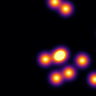

In [ ]:
from src.guassian import get_heatmaps

keypoints = first_sample['joints']
heatmaps = get_heatmaps(sample_image_with_bbox, keypoints)

heatmaps.shape

## Create a single summed heatmap for 
joined_heatmap = heatmaps.sum(dim=0)


joined_color_heatmap = cm(joined_heatmap)

display(torchvision.transforms.functional.to_pil_image(joined_color_heatmap))




# Show Joined Images

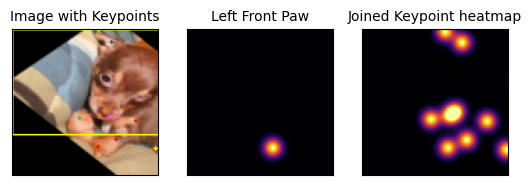

In [ ]:
f = plt.figure()
f.add_subplot(1,3, 1)
plt.title('Image with Keypoints', fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(torchvision.transforms.functional.to_pil_image(sample_image_with_bbox))
f.add_subplot(1,3, 2)
plt.title('Left Front Paw', fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(torchvision.transforms.functional.to_pil_image(left_front_paw_color_heatmap))
f.add_subplot(1,3, 3)
plt.title('Joined Keypoint heatmap', fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(torchvision.transforms.functional.to_pil_image(joined_color_heatmap))
plt.show(block=True)

# Use Rescale and HeatMaps Transforms

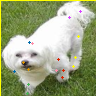

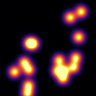

In [ ]:
from torchvision import transforms
from src.rescale import Rescale
from src.heatmaps import HeatMaps

composed_transforms = transforms.Compose([Rescale(256), HeatMaps(std_dev=4)])

dog_pose_train_data_set_with_heatmaps = DogPoseDataSet(
    images_dir = "../data/Images/", 
    np_split_file="../data/annotations/train_stanford_StanfordExtra_v12.npy", 
    annotations_json_file="../data/annotations/StanfordExtra_v12.json",
    transform=composed_transforms)

rescaled_sample_with_heatmaps = None

for i, sample in enumerate(TestDataSetNoNormalization):
    rescaled_sample_with_heatmaps = sample
    if (i == image_index):
        break

sample_image_with_bbox = add_bbox_and_keypoints(rescaled_sample_with_heatmaps['image'], rescaled_sample_with_heatmaps['img_bbox'], rescaled_sample_with_heatmaps['joints'], keypoint_colors)

display(torchvision.transforms.functional.to_pil_image(sample_image_with_bbox))


sample_heatmaps = sample['heatmaps']


## Create a single summed heatmap for 
joined_sample_heatmaps = sample_heatmaps.sum(dim=0)


joined_sample_color_heatmap = cm(joined_sample_heatmaps)

display(torchvision.transforms.functional.to_pil_image(joined_sample_color_heatmap))

# Convert heatmap back to joints
We use max activation vs CoM (center of Mass)

Looking at the results CoM is probs our best bet for now, but we can 

The center of mass is sum(mi * xi)/m, sum(mi * yi)/m where mi are the masses (= elements of the array) and xi, yi are the coordinates (indices of the array). m is the total mass, i.e. sum(mi).



In [ ]:
from src.guassian import heatmaps_to_keypoints_CoM, heatmaps_to_keypoints_max_activation


keypoints_from_heatmaps = heatmaps_to_keypoints_max_activation(sample_heatmaps)
com_keypoints_from_heatmaps = heatmaps_to_keypoints_CoM(sample_heatmaps)

print(keypoints_from_heatmaps)
print(com_keypoints_from_heatmaps)
print(rescaled_sample_with_heatmaps['joints'])

[(63, 78), (64, 70), (59, 60), (73, 67), (75, 57), (78, 37), (27, 93), (28, 85), (0, 0), (0, 0), (0, 0), (0, 0), (70, 17), (81, 11), (33, 43), (29, 43), (24, 62), (28, 69), (57, 71), (14, 71), (0, 0), (0, 0), (0, 0), (0, 0)]
[(62.57778174592953, 77.90155140043538), (63.64444247326166, 70.03278236794013), (58.66667059034815, 59.80328259560073), (73.24444311595197, 66.8852440842505), (75.37777019371963, 57.442621523500286), (78.22208994024318, 36.72131149747537), (27.02222341442341, 91.26921037135598), (28.08888843376271, 84.93381772335499), (0, 0), (0, 0), (0, 0), (0, 0), (69.68888773067707, 17.049281390527856), (80.70945445057887, 11.299202447385884), (32.71111455539525, 43.278692479786), (29.15555697914637, 42.754098771527836), (23.940739820578184, 62.07650171408319), (28.444445876032674, 69.24590597757941), (56.9582652327658, 70.55097715100946), (14.066241350651145, 71.40255128689253), (0, 0), (0, 0), (0, 0), (0, 0)]
[[62.57777777777778, 77.90163934426229, 1], [63.644444444444446, 70

# Center of Mass Example

In [ ]:
import torch

from src.guassian import CoM_activation

t = torch.tensor([[0, 0, 0],
              [0, 4, 4],
              [0, 0, 0]])

print(CoM_activation(t))

(1.5, 1.0)


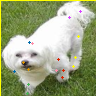

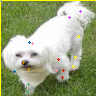

In [ ]:

com_keypoints_from_heatmaps_alt = []

for joint in com_keypoints_from_heatmaps:
    x, y = joint
    ## just force visible for testing
    com_keypoints_from_heatmaps_alt.append([x, y, 1])

sample_image_with_com_keypoints = add_bbox_and_keypoints(rescaled_sample_with_heatmaps['image'], rescaled_sample_with_heatmaps['img_bbox'], com_keypoints_from_heatmaps_alt, keypoint_colors)
display(torchvision.transforms.functional.to_pil_image(sample_image_with_bbox))
display(torchvision.transforms.functional.to_pil_image(sample_image_with_com_keypoints))